# <font color='darkblue'>Women's E-Commerce Clothing Reviews.. </font>
![Screenshot 2021-12-18 125058](https://user-images.githubusercontent.com/93244403/147391538-bd5bdde2-90d3-453d-b137-91ff31c73a0c.png)

#  <a name=Appendix>Appendix:</a>

- click on the links:
>1. <a href=#imports>Imports</a>
>2. <a href=#def>Helper Function</a>
>3. <a href=#Load>Load Data</a>
>4. <a href=#Cleaning>Data Cleaning</a>
>5. <a href=#fea>Feature Engineering</a>
>6. <a href=#EDA>EDA & Visulizations</a>  
>7. <a href=#class>Classification</a>
>8. <a href=#Topic>Topic Modeling </a>
>9. <a href=#clus>Clustring</a>

# <a name='imports'>Libraries Imports</a> 

In [63]:
print("importing.....",end="",flush=True)

import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

#NLP
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer,WordNetLemmatizer
from nltk.corpus import wordnet

# import sklearn
from sklearn.preprocessing import scale ,StandardScaler
from sklearn.cluster import KMeans ,AgglomerativeClustering
from sklearn.datasets import make_blobs ,fetch_openml
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, precision_score, fbeta_score ,silhouette_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD ,NMF
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV ,train_test_split

import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
from wordcloud import WordCloud 
from pprint import pprint

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
print('[done]')

importing.....[done]


 #### <a href='#Appendix'>Return to Appendix </a> 

# <a name='def'>Helper function</a> 

In [64]:
# for text pre-processing

def preprocess(text):
    text = text.lower() #lowercase text
    text=text.strip()  #get rid of leading/trailing whitespace 
    text=re.compile('<.*?>').sub('', text) #Remove HTML tags/markups
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  #Replace punctuation with space. Careful since punctuation can sometime be useful
    text = re.sub('\s+', ' ', text)  #Remove extra space and tabs
    text = re.sub(r'\[[0-9]*\]',' ',text) #[0-9] matches any digit (0 to 10000...)
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) #matches any digit from 0 to 100000..., \D matches non-digits
    text = re.sub(r'\s+',' ',text) #\s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace 
    
    return text

def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)


snow = SnowballStemmer('english')

def stemming(string):
    a=[snow.stem(i) for i in word_tokenize(string) ]
    return " ".join(a)

# for all models in classification
def model_eval(mdl_local, X_local, y_local, eval_name = "Train", bta=1):
    
    y_pred = mdl_local.predict(X_local)
    
    print(f"________________ {eval_name} Metrics______________")
    acc = mdl_local.score(X_local , y_local)
    print("Accuarcy score:", acc)
    prec = precision_score(y_local, y_pred )
    print("Precision Score:", prec)
    recall = recall_score(y_local, y_pred)
    print("Recall Score:", recall)
    fbta = fbeta_score( y_local, y_pred, beta=bta)
    print(f"F{bta} Score:", fbta)
    
    return {f"{eval_name}_acc":acc, f"{eval_name}_prec":prec, f"{eval_name}_recall":recall, f"{eval_name}_fbta":fbta}
    
    
def modeling(expr_name, mdl_local, X_train_local, y_train_local, X_test_local, y_test_local):

    mdl_local.fit(X_train_local, y_train_local)
    print(f"################### {expr_name} ###################")
    expr_metric_dict = model_eval(mdl_local, X_train_local, y_train_local, eval_name = "Train", bta=1)
    expr_metric_dict.update(model_eval(mdl_local, X_test_local, y_test_local, eval_name = "Test", bta=1))
    
    expr_metric_dict["expr_name"] = expr_name
    
    return mdl_local, expr_metric_dict

def make_exprs(exprs_local: list):
    exprs = exprs_local
    list_metics = []
    list_models = []
    for model, metric in exprs:
        list_models.append(model)
        list_metics.append(metric)
    return list_models, pd.DataFrame(list_metics)

# for display topices modling
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

 #### <a href='#Appendix'>Return to Appendix </a> 

# <a name='Load'>Load Data </a> 

In [65]:
df= pd.read_csv('Womens Clothing Reviews.csv',nrows=2000)

In [66]:
df.head(3)

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses


 #### <a href='#Appendix'>Return to Appendix </a> 

# <a name='Cleaning'>Data Cleaning </a>

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               2000 non-null   int64 
 1   Clothing ID              2000 non-null   int64 
 2   Age                      2000 non-null   int64 
 3   Title                    1652 non-null   object
 4   Review Text              1932 non-null   object
 5   Rating                   2000 non-null   int64 
 6   Recommended IND          2000 non-null   int64 
 7   Positive Feedback Count  2000 non-null   int64 
 8   Division Name            2000 non-null   object
 9   Department Name          2000 non-null   object
 10  Class Name               2000 non-null   object
dtypes: int64(6), object(5)
memory usage: 172.0+ KB


In [68]:
df.shape

(2000, 11)

### It show that we have 6 Numerical with Integer variable and 5 Categorical variable with object datatype .


In [69]:
df.isna().sum() # check if we have Nulls ..

Unnamed: 0                   0
Clothing ID                  0
Age                          0
Title                      348
Review Text                 68
Rating                       0
Recommended IND              0
Positive Feedback Count      0
Division Name                0
Department Name              0
Class Name                   0
dtype: int64

In [70]:
df.duplicated().sum() # check if we have Duplicates ..

0

### We have some nulls & not have a Duplicates, to Deal with them

In [71]:
df.drop('Unnamed: 0',axis =1, inplace= True) # drop id number..

In [72]:
df.drop('Title',axis =1, inplace= True) # drop titles of Reviews..

In [73]:
df.isna().sum()

Clothing ID                 0
Age                         0
Review Text                68
Rating                      0
Recommended IND             0
Positive Feedback Count     0
Division Name               0
Department Name             0
Class Name                  0
dtype: int64

In [74]:
df = df.dropna() # drop all nulls in dataframe 

In [75]:
df.isna().sum() # check of nulls 

Clothing ID                0
Age                        0
Review Text                0
Rating                     0
Recommended IND            0
Positive Feedback Count    0
Division Name              0
Department Name            0
Class Name                 0
dtype: int64

 #### <a href='#Appendix'>Return to Appendix </a> 

# <a name='fea'>Feature Engineering </a>

In [76]:
df['Division Name'].unique() # how

array(['Initmates', 'General', 'General Petite'], dtype=object)

In [77]:
df['Department Name'].unique() 

array(['Intimate', 'Dresses', 'Bottoms', 'Tops', 'Jackets', 'Trend'],
      dtype=object)

In [78]:
df['Class Name'].unique()

array(['Intimates', 'Dresses', 'Pants', 'Blouses', 'Knits', 'Outerwear',
       'Lounge', 'Sweaters', 'Skirts', 'Fine gauge', 'Sleep', 'Jackets',
       'Swim', 'Trend', 'Jeans', 'Legwear', 'Shorts', 'Layering'],
      dtype=object)

In [79]:
# Relation between Division name, Department name and Class name? 
df[['Division Name','Department Name','Class Name']].groupby(['Division Name','Department Name','Class Name']).agg('count')

Empty DataFrame
Columns: []
Index: [(General, Bottoms, Jeans), (General, Bottoms, Pants), (General, Bottoms, Shorts), (General, Bottoms, Skirts), (General, Dresses, Dresses), (General, Jackets, Jackets), (General, Jackets, Outerwear), (General, Tops, Blouses), (General, Tops, Fine gauge), (General, Tops, Knits), (General, Tops, Sweaters), (General, Trend, Trend), (General Petite, Bottoms, Jeans), (General Petite, Bottoms, Pants), (General Petite, Bottoms, Skirts), (General Petite, Dresses, Dresses), (General Petite, Intimate, Lounge), (General Petite, Jackets, Jackets), (General Petite, Tops, Blouses), (General Petite, Tops, Fine gauge), (General Petite, Tops, Knits), (General Petite, Tops, Sweaters), (General Petite, Trend, Trend), (Initmates, Intimate, Intimates), (Initmates, Intimate, Layering), (Initmates, Intimate, Legwear), (Initmates, Intimate, Lounge), (Initmates, Intimate, Sleep), (Initmates, Intimate, Swim)]

 #### <a href='#Appendix'>Return to Appendix </a> 

 # <a name='EDA'>EDA & Visulizations</a>

## 1- Visualizing the highest rating scores 

In [80]:
df.Rating.value_counts()

5    1030
4     439
3     250
2     150
1      63
Name: Rating, dtype: int64

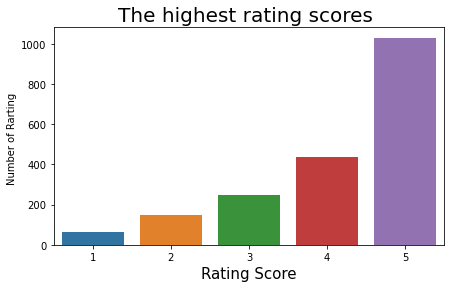

In [81]:
plt.figure(figsize=(7,4))
plt.rcParams.update
sns.countplot('Rating', data = df)

plt.title('The highest rating scores ', fontsize=20)
plt.ylabel('Number of Rarting ', fontsize=10)
plt.xlabel('Rating Score', fontsize=15);

## 2- Visualizing Positive Reviews Vs. Negative Reviews

In [82]:
df["Review_Type"] = df["Rating"].apply(lambda x: "Negative Reviews" if x <= 2 else "Positive Reviews")
reviews_df_plot = df[["Review Text", "Review_Type"]]
reviews_df_plot.head(6)

,Review Text,Review_Type
0,Absolutely wonderful - silky and sexy and comf...,Positive Reviews
1,Love this dress! it's sooo pretty. i happene...,Positive Reviews
2,I had such high hopes for this dress and reall...,Positive Reviews
3,"I love, love, love this jumpsuit. it's fun, fl...",Positive Reviews
4,This shirt is very flattering to all due to th...,Positive Reviews
5,"I love tracy reese dresses, but this one is no...",Negative Reviews


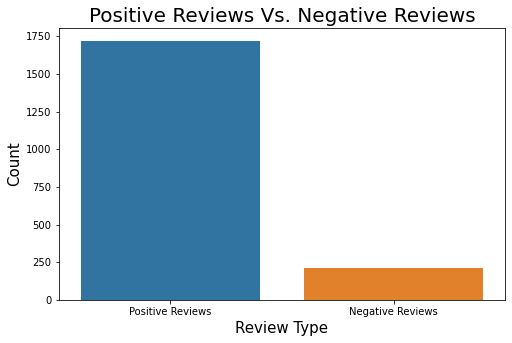

In [83]:
plt.figure(figsize=(8,5))
plt.rcParams.update({'font.size': 10})
sns.countplot('Review_Type', data = reviews_df_plot)

plt.title('Positive Reviews Vs. Negative Reviews', fontsize=20)
plt.ylabel('Count', fontsize=15)
plt.xlabel('Review Type', fontsize=15);

## 3- Visualizing Recommended Products Vs. Not Recommended Products

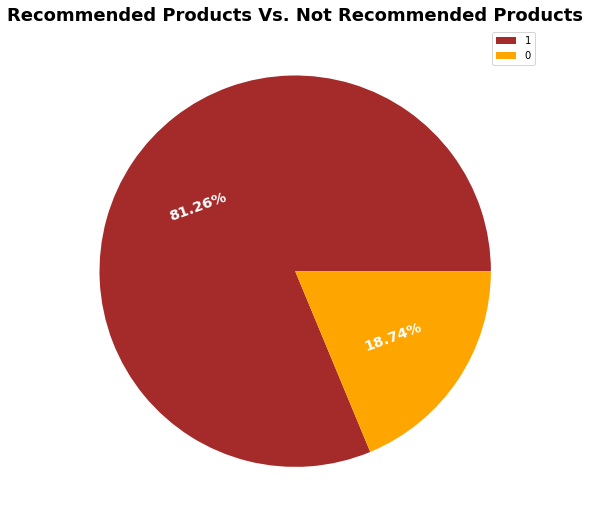

In [84]:
plt.figure(figsize = (10, 9))
plt.pie(pd.value_counts(df['Recommended IND']),
       labels = [1,0],
       colors = ['brown', 'orange'],
       autopct = '%.2f%%',
       textprops = {'size' : 'x-large',
                   'fontweight' : 'bold',
                   'rotation' : '20',
                   'color' : 'w'})

plt.legend()
plt.title('Recommended Products Vs. Not Recommended Products', fontsize = 18, fontweight = 'bold')
plt.show()

## 4- Visualizing Categorical name of the product high level division

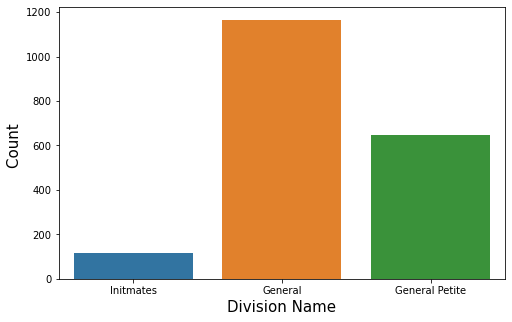

In [85]:
plt.figure(figsize=(8,5))
plt.rcParams.update
sns.countplot('Division Name', data = df)

plt.ylabel('Count ', fontsize=15)
plt.xlabel('Division Name', fontsize=15);

## 5- Visualizing Categorical name of the product department name

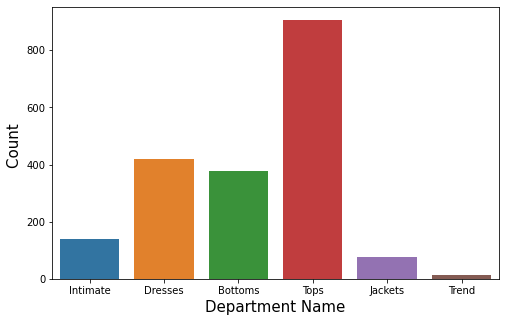

In [86]:
plt.figure(figsize=(8,5))
plt.rcParams.update
sns.countplot('Department Name', data = df)

plt.ylabel('Count ', fontsize=15)
plt.xlabel('Department Name', fontsize=15);

## 6- Categorical name of the product class name

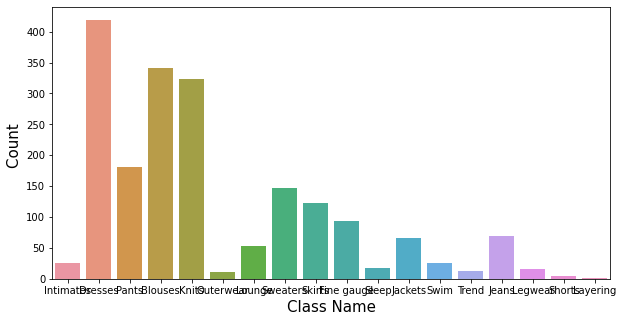

In [87]:
plt.figure(figsize=(10,5))
plt.rcParams.update
sns.countplot('Class Name', data = df)

plt.ylabel('Count ', fontsize=15)
plt.xlabel('Class Name', fontsize=15);

## 7- Visualizing positive and negative words Using Word Cloud

In [88]:
df['Rating'] = df['Rating'].apply(lambda x: 1 if x >= 2 else 0) 

In [89]:
posite = df[df['Rating'] == 1 ]
negative = df[df['Rating'] == 0]

# Positive Words

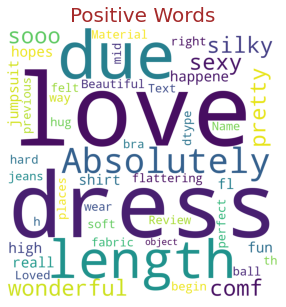

In [90]:
plt.rcParams['figure.figsize'] = (8, 5)
plt.style.use('fast')

wc = WordCloud(background_color = 'white', width = 1000, height = 1000).generate(str(posite['Review Text']))
plt.title('Positive Words', fontsize = 20, color = 'brown')

plt.imshow(wc)
plt.axis('off')
plt.show()

# Negative Words

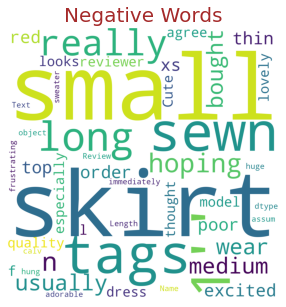

In [91]:
plt.rcParams['figure.figsize'] = (8, 5)
plt.style.use('fast')

wc = WordCloud(background_color = 'white', width = 1500, height = 1500).generate(str(negative['Review Text']))
plt.title('Negative Words', fontsize = 20, color = 'brown')

plt.imshow(wc)
plt.axis('off')
plt.show()

 #### <a href='#Appendix'>Return to Appendix </a> 

 # <a name='class'>Classification</a>

In [92]:
#### Data Spliting
X = df["Review Text"]
y = df["Recommended IND"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=True, random_state = 42)

In [93]:
# Count Vector
cv = CountVectorizer(stop_words="english")
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

# TFIDF
tf = TfidfVectorizer(stop_words="english")
X_train_tf = tf.fit_transform(X_train)
X_test_tf = tf.transform(X_test)

# TFIDF
tf_2 = TfidfVectorizer(ngram_range = (1,2), stop_words="english")
X_train_tf_2 = tf.fit_transform(X_train)
X_test_tf_2 = tf.transform(X_test)

In [94]:
lr=LogisticRegression()
models, metric_df = make_exprs([    modeling("LogisticRegression with CV",LogisticRegression(), 
                                             X_train_cv, y_train, X_test_cv, y_test),
                                    modeling("LogisticRegression with TFIDF", LogisticRegression(),
                                             X_train_tf, y_train, X_test_tf, y_test),
                                    modeling("Naive Bayes with CV", MultinomialNB(),
                                             X_train_cv, y_train, X_test_cv, y_test),
                                    modeling("Naive Bayes with TFIDf", MultinomialNB(),
                                             X_train_tf, y_train, X_test_tf, y_test),
                                    modeling("LogisticRegression with TFIDF ngram_range = (1,2)",
                                             LogisticRegression(), X_train_tf_2, y_train, X_test_tf_2, y_test),
                                    modeling("Naive Bayes with TFIDF ngram_range = (1,2)",
                                             MultinomialNB(), X_train_tf_2, y_train, X_test_tf_2, y_test)
                                    ])

################### LogisticRegression with CV ###################
________________ Train Metrics______________
Accuarcy score: 0.9948220064724919
Precision Score: 0.9936858721389108
Recall Score: 1.0
F1 Score: 0.9968329374505146
________________ Test Metrics______________
Accuarcy score: 0.8604651162790697
Precision Score: 0.8835820895522388
Recall Score: 0.9517684887459807
F1 Score: 0.9164086687306502
################### LogisticRegression with TFIDF ###################
________________ Train Metrics______________
Accuarcy score: 0.8537216828478964
Precision Score: 0.8487508440243079
Recall Score: 0.9984114376489277
F1 Score: 0.9175182481751825
________________ Test Metrics______________
Accuarcy score: 0.8113695090439277
Precision Score: 0.8131578947368421
Recall Score: 0.9935691318327974
F1 Score: 0.894356005788712
################### Naive Bayes with CV ###################
________________ Train Metrics______________
Accuarcy score: 0.9533980582524272
Precision Score: 0.9520182787

In [95]:
metric_df

,Train_acc,Train_prec,Train_recall,Train_fbta,Test_acc,Test_prec,Test_recall,Test_fbta,expr_name
0,0.994822,0.993686,1.000000,0.996833,0.860465,0.883582,0.951768,0.916409,LogisticRegression with CV
1,0.853722,0.848751,0.998411,0.917518,0.811370,0.813158,0.993569,0.894356,LogisticRegression with TFIDF
2,0.953398,0.952018,0.992851,0.972006,0.844961,0.857550,0.967846,0.909366,Naive Bayes with CV
3,0.820065,0.819128,1.000000,0.900572,0.803618,0.803618,1.000000,0.891117,Naive Bayes with TFIDf
4,0.853722,0.848751,0.998411,0.917518,0.811370,0.813158,0.993569,0.894356,"LogisticRegression with TFIDF ngram_range = (1,2)"
5,0.820065,0.819128,1.000000,0.900572,0.803618,0.803618,1.000000,0.891117,"Naive Bayes with TFIDF ngram_range = (1,2)"


In [96]:
models

[LogisticRegression(),
 LogisticRegression(),
 MultinomialNB(),
 MultinomialNB(),
 LogisticRegression(),
 MultinomialNB()]

 #### <a href='#Appendix'>Return to Appendix </a> 

 # <a name='Topic'>Topic Modeling</a>

## LSA Model

In [97]:
vectorizer = CountVectorizer(stop_words='english')
doc_word = vectorizer.fit_transform(df['Review Text'])
doc_word.shape

(1932, 4688)

In [98]:
lsa = TruncatedSVD(10)
doc_topic = lsa.fit_transform(doc_word)

In [99]:
display_topics(lsa, vectorizer.get_feature_names(), 10)


Topic  0
size, dress, love, fit, like, just, wear, small, great, color

Topic  1
dress, dresses, fabric, saw, wedding, belt, bra, loved, wearing, slip

Topic  2
size, small, dress, ordered, fit, true, medium, usual, petite, usually

Topic  3
like, just, look, fabric, really, fit, way, looks, short, looked

Topic  4
like, size, love, looks, shirt, look, wear, fits, cute, material

Topic  5
great, wear, looks, color, shirt, jeans, bought, medium, dress, summer

Topic  6
small, wear, xs, medium, usually, just, runs, extra, arms, retailer

Topic  7
just, wear, fabric, beautiful, size, right, color, large, really, skirt

Topic  8
wear, fit, perfect, pants, like, shirt, large, comfortable, pair, perfectly

Topic  9
color, nice, fabric, sweater, beautiful, perfect, wear, green, skirt, soft


## NMF Model

In [100]:
nmf_model = NMF(10)
doc_topic = nmf_model.fit_transform(doc_word)

In [101]:
display_topics(nmf_model, vectorizer.get_feature_names(), 10)


Topic  0
love, little, perfect, fits, soft, comfortable, pants, colors, sweater, skirt

Topic  1
dress, fabric, dresses, material, flattering, saw, loved, wearing, did, perfect

Topic  2
size, true, ordered, large, fits, usual, store, material, skirt, big

Topic  3
like, look, really, looks, model, material, looked, fabric, way, cute

Topic  4
fit, perfect, petite, waist, pants, length, ordered, perfectly, nice, flattering

Topic  5
great, looks, jeans, fits, comfortable, shirt, black, bought, flattering, quality

Topic  6
small, xs, medium, usually, runs, ordered, petite, lbs, extra, arms

Topic  7
just, fabric, right, short, bit, really, beautiful, length, little, look

Topic  8
wear, perfect, shirt, bought, comfortable, usually, large, bra, pretty, medium

Topic  9
color, sweater, nice, beautiful, green, ordered, soft, flattering, coat, long


## LDA Model

In [102]:
lda_model = LatentDirichletAllocation(n_components=10,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )

lda_output = lda_model.fit_transform(doc_word)

print(lda_model)

LatentDirichletAllocation(learning_method='online', n_jobs=-1, random_state=100)


In [103]:
display_topics(lda_model, vectorizer.get_feature_names(), 10)


Topic  0
straps, bra, wool, yes, vest, time, 39, problem, piece, paid

Topic  1
wear, size, bust, large, perfect, leggings, sweater, fits, medium, looser

Topic  2
sticky, dots, weather, threads, month, 36ddd, boxiness, velcro, twin, widens

Topic  3
seasons, beauty, itchy, drapey, skinnies, luxurious, thread, rust, voluminous, unexpected

Topic  4
awhile, cleaned, checked, edging, snatched, stores, result, represented, determined, homework

Topic  5
night, cover, cold, shrink, dryer, embroidery, hug, favorite, begin, boucle

Topic  6
high, took, perfect, jeans, look, need, waist, tailor, right, linen

Topic  7
size, dress, love, fit, like, great, just, color, fabric, small

Topic  8
cuter, vest, trend, closet, shoes, navy, dressed, flops, cardi, paired

Topic  9
suit, waistband, im, 38, 36d, 10, bathing, swimsuit, fabrics, perfection


In [104]:
search_params = {'n_components': [5, 6, 8], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# increase number of combos here if tuning results are not yet satisfying
param_combos = 5

# Init Grid Search Class
model = RandomizedSearchCV(lda, search_params, n_iter=param_combos)

# Do the Grid Search
model.fit(doc_word)

RandomizedSearchCV(estimator=LatentDirichletAllocation(), n_iter=5,
                   param_distributions={'learning_decay': [0.5, 0.7, 0.9],
                                        'n_components': [5, 6, 8]})

In [105]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

Best Model's Params:  {'n_components': 5, 'learning_decay': 0.5}


In [106]:
display_topics(best_lda_model, vectorizer.get_feature_names(), 10)


Topic  0
like, dress, size, love, just, short, small, petite, cute, look

Topic  1
dress, love, fit, size, just, wear, fabric, small, great, perfect

Topic  2
great, like, dress, just, fit, work, size, blue, quality, good

Topic  3
size, wear, love, great, like, fit, color, shirt, ordered, really

Topic  4
fabric, beautiful, color, sweater, size, look, skirt, like, got, just


In [107]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(doc_word)
# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]
# index names
docnames = ["Doc" + str(i) for i in range(len(df))]
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)
def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)
# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.030000,0.870000,0.030000,0.030000,0.030000,1
Doc1,0.010000,0.750000,0.010000,0.010000,0.220000,1
Doc2,0.000000,0.980000,0.000000,0.000000,0.000000,1
Doc3,0.020000,0.930000,0.020000,0.020000,0.020000,1
Doc4,0.010000,0.210000,0.010000,0.740000,0.010000,3
Doc5,0.980000,0.010000,0.010000,0.010000,0.010000,0
Doc6,0.000000,0.000000,0.000000,0.000000,0.980000,4
Doc7,0.500000,0.490000,0.000000,0.000000,0.000000,0
Doc8,0.010000,0.550000,0.010000,0.410000,0.010000,1
Doc9,0.010000,0.980000,0.010000,0.010000,0.010000,1


In [108]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,1,764
1,3,644
2,0,328
3,2,104
4,4,92


 #### <a href='#Appendix'>Return to Appendix </a> 

# <a name='clus'>Clustring</a>

In [109]:
X = df_document_topic.drop("dominant_topic", axis="columns")

In [110]:
sil_list = []
k_list = []
for i in range(2, 15):
    agg = AgglomerativeClustering(n_clusters=i,linkage='ward')
    cluster_label = agg.fit_predict(X)
    k_list.append(i)
    sil_list.append(silhouette_score(X, cluster_label))
for i in range(0, 12):
    print(k_list[i], sil_list[i])

2 0.47699961366712823
3 0.6088683639725863
4 0.6632911349666439
5 0.6899860280207357
6 0.6602088679629551
7 0.6606789786290086
8 0.6891409016823548
9 0.685901555880121
10 0.7035105007321164
11 0.7036118414357231
12 0.7083408407028096
13 0.7106118783833745


In [111]:
agg = AgglomerativeClustering(n_clusters=13,linkage='ward')
cluster_label = agg.fit_predict(X)
X_new = X.copy()
X_new["cluster"] = cluster_label

In [112]:
X_new.groupby("cluster").mean()

,Topic0,Topic1,Topic2,Topic3,Topic4
cluster,,,,,
0,0.034898,0.548163,0.195714,0.009388,0.214694
1,0.424200,0.009600,0.014000,0.543600,0.011200
2,0.049186,0.022674,0.890116,0.029070,0.010349
3,0.621136,0.172727,0.008182,0.034318,0.166364
4,0.015357,0.379554,0.009911,0.585625,0.011696
5,0.012870,0.013091,0.017682,0.940353,0.018874
6,0.945949,0.010717,0.015696,0.017468,0.011519
7,0.011290,0.010968,0.426129,0.544194,0.010323
8,0.018622,0.941261,0.016420,0.012319,0.013445


In [113]:
ss = StandardScaler()
X_over_std = ss.fit_transform(X)

In [114]:
# knn
km = KMeans()
km.fit(X_over_std)

KMeans()

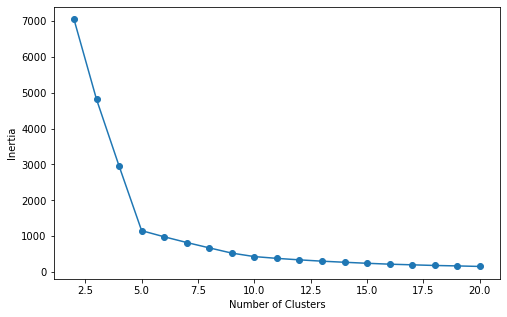

In [115]:
inertia = []
list_num_clusters = list(range(2,21))
for num_clusters in list_num_clusters:
    km = KMeans(n_clusters=num_clusters)
    km.fit(X_over_std)
    inertia.append(km.inertia_)
    
plt.plot(list_num_clusters,inertia)
plt.scatter(list_num_clusters,inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia');

In [116]:
for num_clusters in range(2,11):
    km = KMeans(n_clusters=num_clusters)
    km.fit(X_over_std)
    
    cluster_labels = km.fit_predict(X_over_std)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_over_std, cluster_labels)
    print(
        km,
        "For n_clusters =",
        num_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

KMeans(n_clusters=2) For n_clusters = 2 The average silhouette_score is : 0.41337842072479586
KMeans(n_clusters=3) For n_clusters = 3 The average silhouette_score is : 0.5555120210094586
KMeans(n_clusters=4) For n_clusters = 4 The average silhouette_score is : 0.6329234474772424
KMeans(n_clusters=5) For n_clusters = 5 The average silhouette_score is : 0.7106312629895878
KMeans(n_clusters=6) For n_clusters = 6 The average silhouette_score is : 0.7133328234587004
KMeans(n_clusters=7) For n_clusters = 7 The average silhouette_score is : 0.698196602699087
KMeans() For n_clusters = 8 The average silhouette_score is : 0.7060006508359473
KMeans(n_clusters=9) For n_clusters = 9 The average silhouette_score is : 0.7019644964411935
KMeans(n_clusters=10) For n_clusters = 10 The average silhouette_score is : 0.730493187458318


In [117]:
km = KMeans(n_clusters=6,random_state=10)
km.fit(X_over_std)

KMeans(n_clusters=6, random_state=10)

In [118]:
df["cluster"] = km.predict(X_over_std)

In [119]:
df= pd.DataFrame(km.cluster_centers_, columns = X.columns)
df

,Topic0,Topic1,Topic2,Topic3,Topic4
0,-0.432693,1.219557,-0.220828,-0.723416,-0.224795
1,2.159685,-0.769626,-0.257811,-0.718360,-0.229300
2,-0.085929,-0.398956,-0.132280,0.563498,-0.007762
3,-0.430213,-0.792082,3.907853,-0.598504,-0.282847
4,-0.421941,-0.762853,-0.269406,-0.636206,4.037032
5,-0.496147,-0.848563,-0.243006,1.549903,-0.257255


In [124]:
# change topics names
df = df.rename(columns= {'Topic0':'Dressy casual',
                       'Topic1': 'Evening wear',
                       'Topic2': 'Casual Wear',
                       'Topic3': 'Business Formal Attire',
                       'Topic4': 'Formal Wear'} )
df

,Dressy casual,Evening wear,Casual Wear,Business Formal Attire,Formal Wear
0,-0.432693,1.219557,-0.220828,-0.723416,-0.224795
1,2.159685,-0.769626,-0.257811,-0.718360,-0.229300
2,-0.085929,-0.398956,-0.132280,0.563498,-0.007762
3,-0.430213,-0.792082,3.907853,-0.598504,-0.282847
4,-0.421941,-0.762853,-0.269406,-0.636206,4.037032
5,-0.496147,-0.848563,-0.243006,1.549903,-0.257255


 #### <a href='#Appendix'>Return to Appendix </a> 